In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle

from keras import Sequential
from keras.layers import Lambda, Dense, Flatten
import tensorflow as tf

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
N = 100000
N2 = int(N/2)
SR_background_data = np.random.multivariate_normal([0,0],[[1,0],[0,1]],N)
SB_background_data = np.random.multivariate_normal([1,0],[[1,0],[0,1]],N)
SR_background_sim = np.random.multivariate_normal([0,0],[[1,0],[0,1]],N)
SB_background_sim = np.random.multivariate_normal([1,0],[[1,0],[0,1]],N)
SR_signal = np.random.multivariate_normal([1.5,1.5],[[0.5,0],[0,0.5]],N)

SR_background_data_fortest = np.random.multivariate_normal([0,0],[[1,0],[0,1]],N*10)
SR_signal_fortest = np.random.multivariate_normal([1.5,1.5],[[0.5,0],[0,0.5]],N*10)

Text(0, 0.5, 'events')

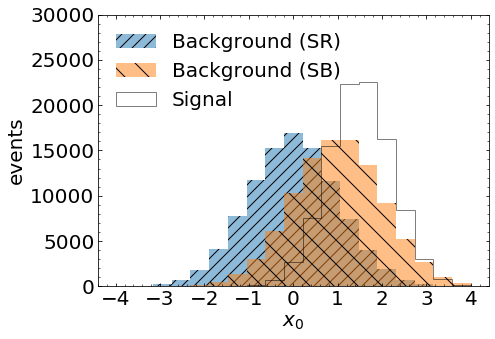

In [3]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.hist(SR_background_data[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SR)",hatch='//')
plt.hist(SB_background_data[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SB)",hatch='\\')
plt.hist(SR_signal[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.ylim([0,30000])
plt.xlabel("$x_0$",fontsize=20)
plt.ylabel("events",fontsize=20)

Text(0, 0.5, 'events')

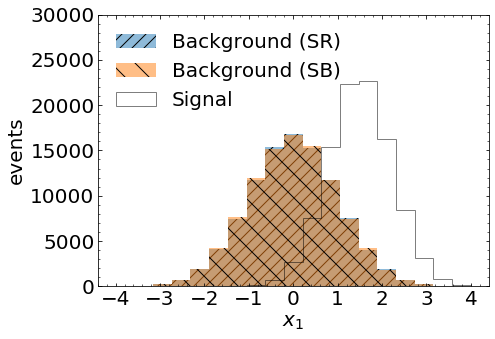

In [4]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.hist(SR_background_data[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SR)",hatch='//')
plt.hist(SB_background_data[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SB)",hatch='\\')
plt.hist(SR_signal[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.ylim([0,30000])
plt.xlabel("$x_1$",fontsize=20)
plt.ylabel("events",fontsize=20)

In [5]:
#First, let's do fully supervised

X_sup_train = np.concatenate([SR_signal,SR_background_data])
Y_sup_train = np.concatenate([np.ones(len(SR_signal)),np.zeros(len(SR_background_data))])

X_sup_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
Y_sup_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])

In [6]:
model_sup = Sequential()
model_sup.add(Dense(64, input_dim=2, activation='relu')) 
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(1, activation='sigmoid'))
model_sup.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup.fit(X_sup_train, Y_sup_train, epochs=10, batch_size=int(0.1*len(X_sup_train)))

scores_sup = model_sup.predict(X_sup_val,batch_size=int(0.1*len(X_sup_val)))
fpr_sup, tpr_sup, _ = roc_curve(Y_sup_val, scores_sup)

Epoch 1/10
200000/200000 [==============================] - 1s 4us/step - loss: 0.6480 - acc: 0.7628
Epoch 2/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.5357 - acc: 0.8459
Epoch 3/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.4205 - acc: 0.8629
Epoch 4/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.3270 - acc: 0.8780
Epoch 5/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.2808 - acc: 0.8854
Epoch 6/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.2641 - acc: 0.8908
Epoch 7/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.2551 - acc: 0.8948
Epoch 8/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.2500 - acc: 0.8976
Epoch 9/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.2475 - acc: 0.8991
Epoch 10/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.2465 - a

In [7]:
model_sup1d = Sequential()
model_sup1d.add(Dense(64, input_dim=1, activation='relu')) 
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(1, activation='sigmoid'))
model_sup1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup1d.fit(X_sup_train[:,1], Y_sup_train, epochs=10, batch_size=int(0.1*len(X_sup_train)))

scores_sup1d = model_sup1d.predict(X_sup_val[:,1],batch_size=int(0.1*len(X_sup_val)))
fpr_sup1d, tpr_sup1d, _ = roc_curve(Y_sup_val, scores_sup1d)

Epoch 1/10
200000/200000 [==============================] - 0s 2us/step - loss: 0.6380 - acc: 0.7187
Epoch 2/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.5585 - acc: 0.7506
Epoch 3/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.5031 - acc: 0.7641
Epoch 4/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.4621 - acc: 0.7917
Epoch 5/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.4315 - acc: 0.8098
Epoch 6/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.4148 - acc: 0.8149
Epoch 7/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.4089 - acc: 0.8154
Epoch 8/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.4079 - acc: 0.8156
Epoch 9/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.4079 - acc: 0.8158
Epoch 10/10
200000/200000 [==============================] - 0s 1us/step - loss: 0.4078 - a

In [8]:
Nsig = 500
print(len(SR_signal[0:Nsig])/len(SR_background_data[0:N2])**0.5)
print(len(SR_signal[0:Nsig])/len(SR_background_data[0:N2]))

2.23606797749979
0.01


In [9]:
#First, let's do data versus sim

X_dvsim_train = np.concatenate([SR_signal[0:Nsig],SR_background_data[0:N2],SR_background_sim[0:N2]])
Y_dvsim_train = np.concatenate([np.ones(len(SR_signal[0:Nsig])),np.ones(len(SR_background_data[0:N2])),np.zeros(len(SR_background_sim[0:N2]))])

X_dvsim_train, Y_dvsim_train = shuffle(X_dvsim_train, Y_dvsim_train)

X_dvsim_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
Y_dvsim_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])

In [10]:
model_dvsim = Sequential()
model_dvsim.add(Dense(64, input_dim=2, activation='relu')) 
model_dvsim.add(Dense(64, activation='relu'))
model_dvsim.add(Dense(64, activation='relu'))
model_dvsim.add(Dense(1, activation='sigmoid'))
model_dvsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_dvsim = model_dvsim.fit(X_dvsim_train, Y_dvsim_train, epochs=10, batch_size=int(0.1*len(X_dvsim_train)))

scores_dvsim = model_dvsim.predict(X_dvsim_val,batch_size=int(0.1*len(X_dvsim_val)))
fpr_dvsim, tpr_dvsim, _ = roc_curve(Y_dvsim_val, scores_dvsim)

Epoch 1/10
100500/100500 [==============================] - 0s 4us/step - loss: 0.6931 - acc: 0.5028
Epoch 2/10
100500/100500 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5034
Epoch 3/10
100500/100500 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5052
Epoch 4/10
100500/100500 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5051
Epoch 5/10
100500/100500 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5057
Epoch 6/10
100500/100500 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5054
Epoch 7/10
100500/100500 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5073
Epoch 8/10
100500/100500 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5063
Epoch 9/10
100500/100500 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5053
Epoch 10/10
100500/100500 [==============================] - 0s 1us/step - loss: 0.6929 - a

In [11]:
#First, let's do data optimal CWoLa

X_ocwola_train = np.concatenate([SR_signal[0:Nsig],SR_background_data[0:N2],SR_background_data[N2:-1]])
Y_ocwola_train = np.concatenate([np.ones(len(SR_signal[0:Nsig])), np.ones(len(SR_background_data[0:N2])),np.zeros(len(SR_background_data[N2:-1]))])

X_ocwola_train, Y_ocwola_train = shuffle(X_ocwola_train, Y_ocwola_train)

X_ocwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
Y_ocwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])

In [12]:
model_ocwola = Sequential()
model_ocwola.add(Dense(64, input_dim=2, activation='relu')) 
model_ocwola.add(Dense(64, activation='relu'))
model_ocwola.add(Dense(64, activation='relu'))
model_ocwola.add(Dense(1, activation='sigmoid'))
model_ocwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_ocwola = model_ocwola.fit(X_ocwola_train, Y_ocwola_train, epochs=10, batch_size=int(0.1*len(X_ocwola_train)))

scores_ocwola = model_ocwola.predict(X_ocwola_val,batch_size=int(0.1*len(X_ocwola_val)))
fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_ocwola_val, scores_ocwola)

Epoch 1/10
100499/100499 [==============================] - 0s 5us/step - loss: 0.6953 - acc: 0.5026
Epoch 2/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.6945 - acc: 0.4963
Epoch 3/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.6938 - acc: 0.5000
Epoch 4/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.6937 - acc: 0.5001
Epoch 5/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5024
Epoch 6/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.6934 - acc: 0.5045
Epoch 7/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.6937 - acc: 0.5044
Epoch 8/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.6934 - acc: 0.5055
Epoch 9/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.6940 - acc: 0.5019
Epoch 10/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.6943 - a

In [13]:
#Next is CWoLa

X_cwola_train = np.concatenate([SR_signal[0:Nsig],SR_background_data[0:N2],SB_background_data[N2:-1]])
Y_cwola_train = np.concatenate([np.ones(len(SR_signal[0:Nsig])), np.ones(len(SR_background_data[0:N2])),np.zeros(len(SB_background_data[N2:-1]))])

X_cwola_train, Y_cwola_train = shuffle(X_cwola_train, Y_cwola_train)

X_cwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
Y_cwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])

In [14]:
model_cwola = Sequential()
model_cwola.add(Dense(64, input_dim=2, activation='relu')) 
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dense(1, activation='sigmoid'))
model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_cwola = model_cwola.fit(X_cwola_train, Y_cwola_train, epochs=10, batch_size=int(0.1*len(X_cwola_train)))

scores_cwola = model_cwola.predict(X_cwola_val,batch_size=int(0.1*len(X_cwola_val)))
fpr_cwola, tpr_cwola, _ = roc_curve(Y_cwola_val, scores_cwola)

Epoch 1/10
100499/100499 [==============================] - 0s 5us/step - loss: 0.6473 - acc: 0.6177
Epoch 2/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.6089 - acc: 0.6826
Epoch 3/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.5921 - acc: 0.6848
Epoch 4/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.5892 - acc: 0.6849
Epoch 5/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.5875 - acc: 0.6862
Epoch 6/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.5862 - acc: 0.6864
Epoch 7/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.5869 - acc: 0.6883
Epoch 8/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.5862 - acc: 0.6879
Epoch 9/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.5871 - acc: 0.6880
Epoch 10/10
100499/100499 [==============================] - 0s 1us/step - loss: 0.5862 - a

In [15]:
#Next is SA-CWoLa

mylambda = 1.

X_sacwola_train = np.concatenate([SR_signal[0:Nsig],SR_background_data[0:N2],SB_background_data[N2:-1],SR_background_sim[0:N2],SB_background_sim[N2:-1]])
Y_sacwola_train = np.concatenate([np.ones(len(SR_signal[0:Nsig])), np.ones(len(SR_background_data[0:N2])),np.zeros(len(SB_background_data[N2:-1])),np.ones(len(SR_background_sim[0:N2])),np.zeros(len(SB_background_sim[N2:-1]))])
W_sacwola_train = np.concatenate([np.ones(len(SR_signal[0:Nsig])), np.ones(len(SR_background_data[0:N2])),np.ones(len(SB_background_data[N2:-1])),-mylambda*np.ones(len(SR_background_sim[0:N2])),-mylambda*np.ones(len(SB_background_sim[N2:-1]))])

X_sacwola_train, Y_sacwola_train, W_sacwola_train = shuffle(X_sacwola_train, Y_sacwola_train,W_sacwola_train)

X_sacwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
Y_sacwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])

In [16]:
model_sacwola = Sequential()
model_sacwola.add(Dense(64, input_dim=2, activation='relu')) 
model_sacwola.add(Dense(64, activation='relu'))
model_sacwola.add(Dense(64, activation='relu'))
model_sacwola.add(Dense(1, activation='sigmoid'))
model_sacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sacwola = model_sacwola.fit(X_sacwola_train, Y_sacwola_train, epochs=10, batch_size=int(0.1*len(X_sacwola_train)),sample_weight=W_sacwola_train)

scores_sacwola = model_sacwola.predict(X_sacwola_val,batch_size=int(0.1*len(X_sacwola_val)))
fpr_sacwola, tpr_sacwola, _ = roc_curve(Y_sacwola_val, scores_sacwola)

Epoch 1/10
200498/200498 [==============================] - 1s 3us/step - loss: 0.0014 - acc: 0.6111
Epoch 2/10
200498/200498 [==============================] - 0s 1us/step - loss: 8.9237e-04 - acc: 0.5126
Epoch 3/10
200498/200498 [==============================] - 0s 1us/step - loss: 6.2554e-04 - acc: 0.4853
Epoch 4/10
200498/200498 [==============================] - 0s 1us/step - loss: 4.1500e-04 - acc: 0.5067
Epoch 5/10
200498/200498 [==============================] - 0s 1us/step - loss: 2.8767e-04 - acc: 0.4859
Epoch 6/10
200498/200498 [==============================] - 0s 1us/step - loss: 3.1662e-04 - acc: 0.4394
Epoch 7/10
200498/200498 [==============================] - 0s 1us/step - loss: 1.3222e-04 - acc: 0.4099
Epoch 8/10
200498/200498 [==============================] - 0s 1us/step - loss: 2.0705e-05 - acc: 0.4052
Epoch 9/10
200498/200498 [==============================] - 0s 1us/step - loss: 1.8573e-04 - acc: 0.4176
Epoch 10/10
200498/200498 [==============================] 

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divid

Text(1.0, 1.0, '$2D$ $Gaussian$ $Example$')

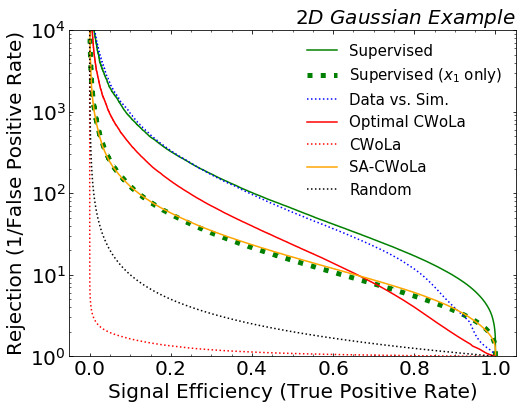

In [18]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)
plt.plot(tpr_dvsim,1./fpr_dvsim,label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_ocwola,1./fpr_ocwola,label="Optimal CWoLa",color="red")
plt.plot(tpr_cwola,1./fpr_cwola,label="CWoLa",color="red",ls=":")
plt.plot(tpr_sacwola,1./fpr_sacwola,label="SA-CWoLa",color="orange")
plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

plt.title("$2D$ $Gaussian$ $Example$",fontsize=20,loc="right")